In [33]:
# required google colab installations
!pip install torchinfo torchmetrics wandb mlxtend==0.22

In [68]:
# import libraries
import random
import math
from pathlib import Path
import sys

from tqdm.auto import tqdm


import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import torchinfo # show model summary

# helper functions 
#from helpers import display_images

# pytorch modules
import torch
from torch.utils.data import DataLoader

# torch vision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn

# vanilla models
#from base_models.VGG_vanilla import VGGVanilla

# metrics module
import torchmetrics

# tracking metrics
import wandb

##### Hyper-parameter Initialisations

In [35]:
config = dict(
    epochs=1,
    learning_rate=1e-3,
    batch_size= 32,
    optimiser="SGD",
    dataset="MNIST",
    architecture="VGG-11", # can be changed to other architectures e.g. "VGG-11", "VGG-13", "VGG16-1"
)

In [36]:
run_name = f"{config['architecture']}_{config['optimiser']}_{config['learning_rate']}_{config['batch_size']}_{config['dataset']}"
print(run_name)

VGG-16-1_SGD_0.001_32_MNIST


In [37]:
# initialise wandb project
wandb.init(project="ECS795P_Vanilla", config=config, name=run_name)

In [38]:
config = wandb.config
print(f"Hyper-parameter configurations: \n{config}")

Hyper-parameter configurations: 
{'epochs': 1, 'learning_rate': 0.001, 'batch_size': 32, 'optimiser': 'SGD', 'dataset': 'MNIST', 'architecture': 'VGG-16-1'}


In [39]:
def display_images(image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    #n_rows, n_cols = 3, 5
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        axs[i%n_rows, i//n_rows].set_title(class_labels[label[i]])
        
    return fig

In [40]:
def display_predicted_images(model, image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display MNIST sample images
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))

    model = model.to("cpu")

    model.eval()
    with torch.inference_mode():
        model_predictions_logits = model(data)
        predictions = nn.functional.softmax(model_predictions_logits, dim=0).argmax(dim=1)

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        title = f"Actual Class {class_labels[label[i]]}\n Predicted Class: {class_labels[predictions[i]]}"
        axs[i%n_rows, i//n_rows].set_title(title)

    return fig

In [41]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current hardware device: {DEVICE}")

Current hardware device: cpu


#### Downloading and Loading Datasets

In [42]:
# image Transforms
image_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
    ])


In [43]:
# load MNIST datasets
# MNIST train data
train_data = datasets.MNIST(
    root="mnist_data",
    train=True,
    transform=image_tranforms,
    download=True,
)

# MNIST test data
test_data = datasets.MNIST(
    root="mnist_data",
    train=False,
    transform=image_tranforms,
    download=True,
)

In [44]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Image size: {np.array(train_data[0][0].shape)}")

Train data size: 60000
Test data size: 10000
Image size: [  3 224 224]


In [45]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=config.batch_size,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=config.batch_size,
)

In [46]:
class_labels = train_data.classes # images class labels
print(f"class labels: {class_labels}")

class labels: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


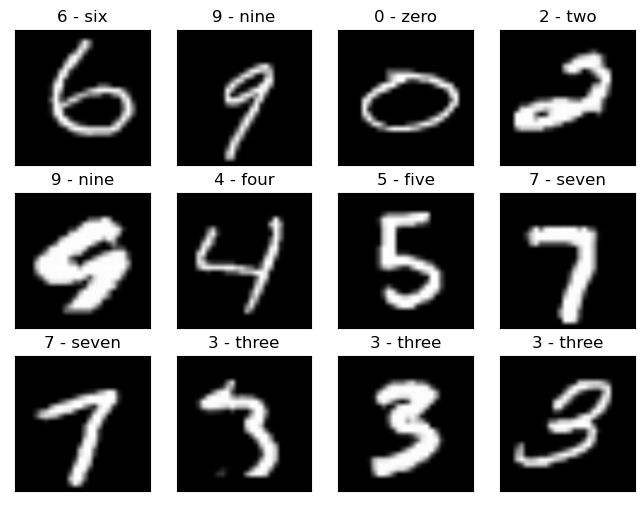

In [75]:
display_images(train_dataloader, class_labels=class_labels, n_cols=4, n_rows=3, figsize=(8,6))
plt.savefig("dataset_sample/MNIST_dataset_sample.jpg")
plt.show()

#### VGG Baseline Model

In [69]:
class VGGVanilla(nn.Module):
     """
     VGG model implementation base on the paper by:

     @article{simonyan2014very,
     title={Very deep convolutional networks for large-scale image recognition},
     author={Simonyan, Karen and Zisserman, Andrew},
     journal={arXiv preprint arXiv:1409.1556},
     year={2014}
     }
     """
     # architecture configurations
     arc_config = {
     "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
     "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
     "C": [64, 64, "M", 128, 128, "M", 256, 256, 1, 256, "M", 512, 512, 1, 512, "M", 512, 512, 1, 512, "M"],
     "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
     "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
     }

     def __init__(self, vgg_type: str = "A", output_classes: int = 1000, p_dropout: float = 0.5):
          """
               
          """
          super().__init__()
          self.conv_layers = self._make_layers(vgg_type) # stack of CNN layers

          # average pool
          self.avg_pool = nn.AdaptiveAvgPool2d((7,7))

          # Fully-Connected (FC) layers
          self.fc_layer = nn.Sequential(
               nn.Linear(512 * 7 * 7, 4096),
               nn.ReLU(),
               nn.Dropout(p=p_dropout),
               nn.Linear(4096, 4096),
               nn.ReLU(),
               nn.Dropout(p=p_dropout),
               nn.Linear(4096, output_classes)
          )
    
     def _make_layers(self, vgg_type: str):
          """
          VGG CNN stack based on provided configuration settings

          Args:
               vgg_type: VGG ConvNet configuration

          Return:
               CNN_stack: developed architecture
          """

          CNN_layers = []
          input_channel = 3 # 3 ==> initial number of channel
          config = self.arc_config[vgg_type]

          is_conv_1 = False # flag for convolution with size 1

          for l in config:
               # add MaxPooling
               if l == "M":
                    CNN_layers.append(nn.MaxPool2d((2,2), stride=(2,2)))
               
               # set flag tochange convolution size
               elif l==1:
                    is_conv_1 = True
               
               else:
                    if not is_conv_1:
                         CNN_layers += [nn.Conv2d(input_channel, l, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(l), 
                                        nn.ReLU()]
                    else:
                         CNN_layers += [nn.Conv2d(input_channel, l, kernel_size=1, stride=1, padding=0), 
                                        nn.BatchNorm2d(l),
                                        nn.ReLU()]
                         is_conv_1 = False # turn off flag

                    input_channel = l

          CNN_stack = nn.Sequential(*CNN_layers)
          return CNN_stack

     def forward(self, x):
          """
          forward pass
          """
          x = self.conv_layers(x)
          x = self.avg_pool(x)
          x = x.view(x.shape[0], -1)
          x = self.fc_layer(x)
          return x


In [70]:
vgg_config_dict = {
    "VGG-11": "A",
    "VGG-13": "B",
    "VGG-16-1": "C",
    "VGG-16": "D",
    "VGG-19": "E"
}
vgg_config = vgg_config_dict[config.architecture]
print(f"VGG configuration: {vgg_config}")

VGG configuration: C


In [71]:
vgg_model = VGGVanilla(vgg_type=vgg_config, output_classes=10)

In [72]:
vgg_model

VGGVanilla(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3

In [73]:
# display model architecture
torchinfo.summary(vgg_model,
                  input_size=(32, 3, 224, 224), 
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=30,
                  row_settings=["var_names"]
                  )

Layer (type (var_name))                  Input Shape                    Output Shape                   Param #                        Trainable
VGGVanilla (VGGVanilla)                  [32, 3, 224, 224]              [32, 10]                       --                             True
├─Sequential (conv_layers)               [32, 3, 224, 224]              [32, 512, 7, 7]                --                             True
│    └─Conv2d (0)                        [32, 3, 224, 224]              [32, 64, 224, 224]             1,792                          True
│    └─ReLU (1)                          [32, 64, 224, 224]             [32, 64, 224, 224]             --                             --
│    └─Conv2d (2)                        [32, 64, 224, 224]             [32, 64, 224, 224]             36,928                         True
│    └─ReLU (3)                          [32, 64, 224, 224]             [32, 64, 224, 224]             --                             --
│    └─MaxPool2d (4)      

In [53]:
loss_fn = nn.CrossEntropyLoss()
if config.optimiser == "SGD":
    optimiser = torch.optim.SGD(vgg_model.parameters(), lr=config.learning_rate)
elif config.optimiser == "ADAM":
    optimiser = torch.optim.Adam(vgg_model.parameters(), lr=config.learning_rate)

In [54]:
# metrics definition
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [55]:
# monitor parameter values i.e weights and biases and model gradients
wandb.watch(vgg_model, criterion=loss_fn, log="all")

[]

In [56]:
def train_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    train_acc, train_loss = 0, 0
    model.train()
    for batch_data, batch_label in train_dataloader:
        batch_data = batch_data.to(DEVICE)
        batch_label = batch_label.to(DEVICE)\

        pred_logits = model(batch_data)

        train_batch_loss = loss_fn(pred_logits, batch_label)
        train_loss += train_batch_loss

        preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
        train_batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
        train_acc += train_batch_acc

        optimiser.zero_grad()

        train_batch_loss.backward()

        optimiser.step()
    
    # average of metrics per batch
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    return train_loss, train_acc

In [57]:
def test_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    test_loss, test_acc =  0, 0
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)

            test_batch_loss = loss_fn(pred_logits, test_batch_label)
            test_loss += test_batch_loss

            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            batch_acc = accuracy_metric(preds.cpu(), test_batch_label.cpu()) * 100
            test_acc += batch_acc
        
        # average of loss metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [58]:
def model_prediction(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    all_preds = []
    model.to(DEVICE)
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)
            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            all_preds.append(preds.to("cpu"))
        
    all_preds_tensor = torch.cat(all_preds)
    return all_preds_tensor

##### Model Training

In [59]:

for epoch in tqdm(range(config.epochs)):

    # MODEL TRAINING
    train_loss, train_accuracy = train_model(vgg_model, train_dataloader)

    # MODEL EVALUATION
    test_loss, test_accuracy = test_model(vgg_model, test_dataloader)
    
    # print training metrics
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss: .3f}\t Training accuracy: {train_accuracy: .3f}", end="\t")
    print(f"Test loss: {test_loss: .3f}\t Test acc: {test_accuracy: .3f}")

    # log epoch metrics to WandB
    epoch_log_dict = {
        "training_accuracy": train_accuracy,
        "training_loss": train_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    wandb.log(epoch_log_dict)



  0%|          | 0/1 [00:30<?, ?it/s]


KeyboardInterrupt: 

### Visualisations

#### Model accuracy and loss


In [ ]:
# show logged metrics
%wandb mustious/ECS795P_Classic

#### Sample Images of Predicted Classes

In [ ]:
predicted_images_fig = display_predicted_images(vgg_model, test_dataloader, class_labels=class_labels, figsize=(15,10))
plt.savefig(f"{config.architecture}_sample_model_prediction.jpg")
plt.show()

# log prediction image in wandb
wandb.log({"sample_predictions": predicted_images_fig})

### Confusion Matrix Visualisation


In [ ]:
predictions = model_prediction(vgg_model, test_dataloader)

confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_labels))
confusion_matrix_tensor = confusion_matrix(predictions, test_data.targets)

confusion_matrix_fig, ax = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names= class_labels,
    figsize=(10, 7))
plt.show()

# log prediction image in wandb
wandb.log({"confusion_matrix": confusion_matrix_fig})